In [0]:
import pandas as pd
import numpy as np
import cv2
import PIL
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline

import keras
from keras.models import Sequential, Model
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1qK81Lenrtzlk6FdoD_u9qo_R-8KfF6XS'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('hot-dog-not-hot-dog.zip')

W0626 16:58:37.833312 140316209891200 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

In [0]:
!unzip -qq hot-dog-not-hot-dog.zip

replace test/hot_dog/133012.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
TEST_PATH = 'test/'
TRAIN_PATH = 'train/'
RESCALE_SIZE = 224

In [0]:
train = Path(TRAIN_PATH)
test  = Path(TEST_PATH)

In [0]:
def create_csv(filename: str, path:Path) -> None:
  with open(filename, 'w') as f:
    for tag in path.iterdir():
      files = tag.rglob('*.jpg')
      for file in files:
        f.write(file.parent.parent.name + '/' + file.parent.name + '/' + file.name + ',' + str(1 if tag.name == "hot_dog" else 0) + '\n')

In [0]:
create_csv('train.csv', train)
create_csv('test.csv', test)

In [0]:
def show(path: str):
  img = cv2.imread(path)
  plt.imshow(img[..., [2,1,0]])

In [0]:
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')

In [0]:
temp = train_df.values
np.random.shuffle(temp)
df = pd.DataFrame(data = temp)

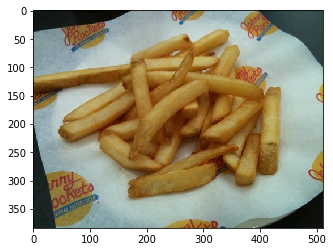

In [0]:
show(df.sample(1).values[0][0])

In [0]:
cv2.imread(df.sample(1).values[0][0]).shape

(512, 384, 3)

In [0]:
def keras_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_path, label = gen_df.sample(1).values[0]
            img = cv2.imread(img_path)
            img = cv2.resize(img, (RESCALE_SIZE, RESCALE_SIZE))
            
            x_batch += [img]
            y_batch += [label]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)
        
        yield x_batch, np.expand_dims(y_batch, -1)

In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras import backend as K
from keras import layers
from keras.models import Sequential
K.tensorflow_backend._get_available_gpus()

W0626 19:22:58.411965 140183670126464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0626 19:22:58.414063 140183670126464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0626 19:22:58.415649 140183670126464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0626 19:22:58.642493 140183670126464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
base_model = VGG16(
    input_shape = (RESCALE_SIZE,RESCALE_SIZE,3),
    include_top = False,
    weights = "imagenet"
)

In [0]:
base_model.trainable = False

In [0]:
base_model.output

<tf.Tensor 'block5_pool_4/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [0]:
model = Sequential([
  base_model,
  layers.Flatten(),
  layers.Dense(1000,activation="relu", name="fc1"),
  layers.Dropout(0.5),
  layers.Dense(1000,activation="relu", name="fc12"),
  layers.Dropout(0.5),
  layers.Dense(500, activation="relu", name="fc2"),
  layers.Dropout(0.5),
  layers.Dense(300, activation="relu", name="fc3"),
  layers.Dense(1,  activation='sigmoid', name="output")
])

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 1000)              25089000  
_________________________________________________________________
dropout_13 (Dropout)         (None, 1000)              0         
_________________________________________________________________
fc12 (Dense)                 (None, 1000)              1001000   
_________________________________________________________________
dropout_14 (Dropout)         (None, 1000)              0         
_________________________________________________________________
fc2 (Dense)                  (None, 500)               500500    
__________

In [33]:
batch_size = 64
model.fit_generator(
    keras_generator(train_df, batch_size),
    steps_per_epoch=200,
    epochs=50,
    verbose=1,
    validation_data=keras_generator(test_df, batch_size),
    validation_steps=200,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    shuffle=True,
    initial_epoch=0
)

Epoch 1/50
200/200 [==============================] - 145s 723ms/step - loss: 0.4313 - acc: 0.8291 - val_loss: 0.8365 - val_acc: 0.8000
Epoch 2/50
200/200 [==============================] - 137s 685ms/step - loss: 0.0263 - acc: 0.9912 - val_loss: 1.0688 - val_acc: 0.7898
Epoch 3/50
200/200 [==============================] - 137s 685ms/step - loss: 0.0176 - acc: 0.9939 - val_loss: 1.7978 - val_acc: 0.7027
Epoch 4/50
200/200 [==============================] - 137s 686ms/step - loss: 0.0309 - acc: 0.9888 - val_loss: 1.4694 - val_acc: 0.7757
Epoch 5/50
200/200 [==============================] - 136s 682ms/step - loss: 0.0165 - acc: 0.9935 - val_loss: 0.9936 - val_acc: 0.7981
Epoch 6/50
200/200 [==============================] - 136s 681ms/step - loss: 0.0338 - acc: 0.9870 - val_loss: 0.8762 - val_acc: 0.7821
Epoch 7/50
200/200 [==============================] - 136s 681ms/step - loss: 0.0237 - acc: 0.9918 - val_loss: 1.2690 - val_acc: 0.7950
Epoch 8/50
200/200 [============================

KeyboardInterrupt: ignored

In [0]:
model.save('model.h5')

In [0]:
import pickle

In [0]:
with open('model.pkl', 'wb') as le_dump_file:
      pickle.dump(model, le_dump_file)

test/not_hot_dog/46325.jpg


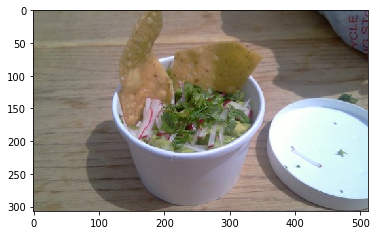

In [50]:
sample_ = test_df.sample(1)
img = cv2.imread(sample_.values[0][0])
label =  sample_.values[0][0]
show(sample_.values[0][0])
print(label)

In [49]:
img = cv2.resize(img, (RESCALE_SIZE, RESCALE_SIZE))
img_2 = np.expand_dims(img, axis = 0)
np.max(model.predict(img_2))

0.0

In [0]:
!pip3 install learntools
from learntools.deep_learning.decode_predictions import decode_predictions

In [55]:
model.model.evaluate_generator(keras_generator(test_df, 64), steps=train_df.shape[0])

/usr/local/lib/python3.6/dist-packages/keras/engine/sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


[2.0812709326715297, 0.7930394869215291]

In [53]:
test_df.shape

(499, 2)